In [158]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt


In [136]:
def clean_data(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].str.replace(",", "").str.replace("$", "").astype(float)
    return df.dropna()

In [159]:
# Function to create a scatter plot comparing actual and predicted values
def plot_actual_vs_predicted(y_actual, y_pred, title):
    plt.scatter(y_actual, y_pred)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)

    # Add a diagonal line to show where the predictions should lie if they were perfect
    min_value = min(y_actual.min(), y_pred.min())
    max_value = max(y_actual.max(), y_pred.max())
    plt.plot([min_value, max_value], [min_value, max_value], 'k--')

    plt.show()

In [137]:
# Read data
data = pd.read_csv("C:/Users/Luxford/Documents/Lesson/AD/factbookv2.csv")

# Filter and process the data
data_dipake = ["GDP", "Exports", "Imports", "Industrial production growth rate", "Investment", "Unemployment rate"]
df = clean_data(data[data_dipake])

# Check for missing values and display the first five rows
print(df.isnull().sum())
df.head()

GDP                                  0
Exports                              0
Imports                              0
Industrial production growth rate    0
Investment                           0
Unemployment rate                    0
dtype: int64


C:\Users\Luxford\AppData\Local\Temp\ipykernel_13688\4068154764.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace(",", "").str.replace("$", "").astype(float)
C:\Users\Luxford\AppData\Local\Temp\ipykernel_13688\4068154764.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].str.replace(",", "").str.replace("$", "").astype(float)


,GDP,Exports,Imports,Industrial production growth rate,Investment,Unemployment rate
0,1.746000e+10,5.524000e+08,2.076000e+09,3.1,18.4,14.8
1,2.123000e+11,3.216000e+10,1.525000e+10,6.0,26.2,25.4
3,4.835000e+11,3.378000e+10,2.206000e+10,12.0,18.3,14.8
4,1.365000e+10,8.500000e+08,1.300000e+09,15.0,19.8,30.0
5,6.117000e+11,8.689000e+10,9.810000e+10,1.9,25.3,5.1


In [138]:
# Normalize the data
scaler = StandardScaler()
df_normalized = scaler.fit_transform(df)

In [139]:
# Split the data into inputs (X) and output (y)
X = df_normalized[:, 1:]
y = df_normalized[:, 0]

In [140]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [147]:
# Create the MLP model
mlp = MLPRegressor(max_iter=500, random_state=42)

In [146]:
# Create a pipeline
pipeline = Pipeline([('scaler', StandardScaler()), ('mlp', mlp)])

In [155]:
# Define the hyperparameter search space
param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (150,), (50, 50), (50, 50, 50), (100, 100), (100, 100, 100)],
    'mlp__activation': ['relu', 'tanh', 'logistic'],
    'mlp__solver': ['adam', 'lbfgs', 'sgd'],
    'mlp__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1],
    'mlp__learning_rate': ['constant', 'adaptive'],
    'mlp__max_iter': [500, 1000],
    'mlp__early_stopping': [True],
    'mlp__validation_fraction': [0.1, 0.2]
}

In [156]:
# Create a cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform the Grid Search
grid_search = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, verbose=2)
grid_search.fit(X, y)

# Print the best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", -grid_search.best_score_)

Fitting 5 folds for each of 2520 candidates, totalling 12600 fits
Best parameters found:  {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__early_stopping': True, 'mlp__hidden_layer_sizes': (100, 100), 'mlp__learning_rate': 'constant', 'mlp__max_iter': 500, 'mlp__solver': 'lbfgs', 'mlp__validation_fraction': 0.1}
Best score found:  0.21814446938075654


Training set - Mean Squared Error:  2.0782941694813083e-05
Training set - R-squared:  0.9999529575579882


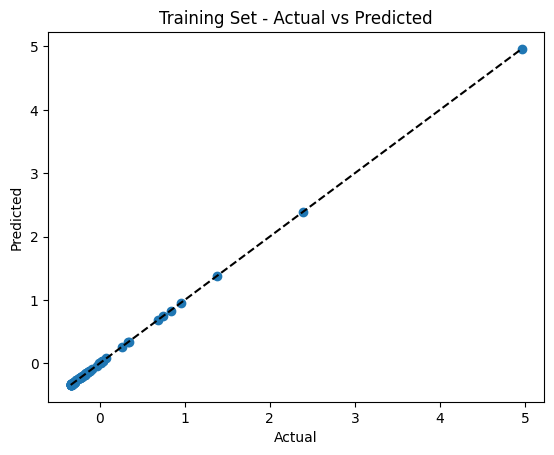

Test set - Mean Squared Error:  5.114359799461037e-06
Test set - R-squared:  0.9999983050293667


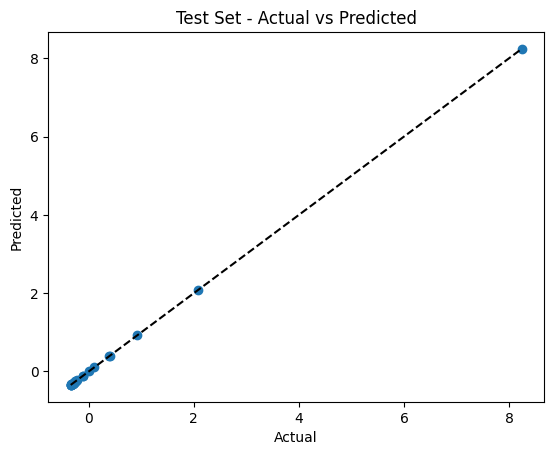

In [160]:
y_train_pred = grid_search.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
print("Training set - Mean Squared Error: ", train_mse)
print("Training set - R-squared: ", train_r2)
plot_actual_vs_predicted(y_train, y_train_pred, "Training Set - Actual vs Predicted")

# Evaluate the model on the test set and plot the results
y_test_pred = grid_search.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print("Test set - Mean Squared Error: ", test_mse)
print("Test set - R-squared: ", test_r2)
plot_actual_vs_predicted(y_test, y_test_pred, "Test Set - Actual vs Predicted")